In [1]:
import csv
import subprocess
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import shutil

In [29]:
class Experiment:
    def __init__(self, functions_file, optimization_file, opt_folder, fig_folder):
        self.functions_file = functions_file
        self.optimization_file = optimization_file
        self.functions_param=[]
        self.optimization_param=[]
        
        
        self.f_param_list_function_id=[]
        self.f_param_list_name=[]
        self.f_param_list_range_low=[]
        self.f_param_list_range_high=[]
        self.f_param_list_dimensions_vector=[]
            
        self.opt_param_list_id = []
        self.opt_param_list_name = []
        self.opt_param_list_config_file = []
            
        self.readFunctionsFile()
        self.readOptimizationFile()
        self.opt_folder = opt_folder
        self.fig_folder = fig_folder
        self.solution_file = "solutions.csv"
        self.solution_df = None
        
        #detect os windows or linux
        if os.name == 'nt':
            # Windows
            self.exec = "../bin/release/project.exe"
        else:
            # other (linux)
            self.exec = "../bin/release/project.o"
        
    def readFunctionsFile(self):
        with open(self.functions_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.functions_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.functions_param)):
            self.f_param_list_function_id.append(self.functions_param[i][0]) #function_id
            self.f_param_list_name.append(self.functions_param[i][1]) # function name
            self.f_param_list_range_low.append(self.functions_param[i][2]) # range low
            self.f_param_list_range_high.append(self.functions_param[i][3]) # range high
            self.f_param_list_dimensions_vector.append(self.functions_param[i][4:]) # dimension vector, from 4 to the last element
            
    def readOptimizationFile(self):
        with open(self.optimization_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.optimization_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.optimization_param)):
            self.opt_param_list_id.append(self.optimization_param[i][0]) #opt algorithm id
            self.opt_param_list_name.append(self.optimization_param[i][1]) #algo name
            self.opt_param_list_config_file.append(self.optimization_param[i][2]) # config file
            
    def delete_all_output_files(self):
        files = glob.glob('a*.csv')
        for f in files:
            os.remove(f)
    def moveFileToOutFolder(self, filename):
        shutil.move(filename, self.opt_folder+filename) # move file to out folder
        
    def merge_all_output_files(self):
        files = glob.glob("a*.csv")

        #print(files)
        solutions=[]
        for f in files:
            with open(f) as csvfile:
                read_csv = csv.reader(csvfile, delimiter=',')
                for i,row in enumerate(read_csv):
                    if i != 0: # first row
                        solutions.append(row)
        #print(solutions)
        
        
        with open(self.solution_file, mode='w') as solution_file:
            writer = csv.writer(solution_file, delimiter=',', lineterminator='\n',quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['algorithm_id'
                             ,'function_id'
                             ,'n_runs'
                             ,'dimensions'
                             ,'range_low'
                             ,'range_high'
                             ,'mean'
                             ,'std_dev'
                             ,'range'
                             ,'median'
                             ,'time_ms'
                             ,'range_min'
                             ,'range_max'
                            ])
            writer.writerows(solutions)
            
    def plot(self):
        df=pd.read_csv(self.opt_folder +'solutions.csv',index_col=False)
        df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
        self.solution_df = df
        
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('algorithm_id'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()
        plt.title('Running time')
        plt.savefig(self.fig_folder+"running_time.png",bbox_inches='tight')
        
   
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
            ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            ax1.plot(data['algorithm_id'],data['median'],label='median')
            ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            locs = [int(i) for i in self.opt_param_list_id]
            names = self.opt_param_list_name
            ax1.set_xticks(locs, minor=False)
            ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
            #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
            fig.suptitle("f%d : %s"%(id, self.f_param_list_name[id-1]), fontsize=15)
            #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
            #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax1.legend()
            ax1.set_xlabel('Algorithm')
            ax1.set_ylabel('Cost')
            ax1.grid()

            ax2.plot(data['algorithm_id'],data['time_ms'])
            ax2.set_ylabel('CPU Total Running time [ms]')
            ax2.set_xlabel('Algorithm')
            ax2.set_xticks(locs, minor=False)
            ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
            ax2.grid()
            plt.savefig(self.fig_folder + "f"+str(id)+".png",bbox_inches='tight')

        
    # run all the algorithm, 18 functions in the same time, using many CPU
    # may cause some problem with CPU clock() time... which register the cpu time of whole program
    # it seems that python is a program which call many subprocess using Popen. As a result, all the subprocess are
    # accessing to the same clock?
    def run(self, n_runs):
        
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.Popen([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            # wait every process to finish
            for p in process_list:
                p.wait()
            print("----finished----alg: %d"%k)
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    # run all the algorithm in sequence one function after another only only 1 CPU
    def runOneByOne(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.run([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            print("----finished----alg: %d"%k)
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    def runAllLinux(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    
                    command_str =  [self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]]
                    command_str = ' '.join(command_str)
                    os.system(command_str +' &') # execute in background

            print("----running---alg: %d"%k)
            print("the files should be collected manually using collectFiles()")
        

        
    def collectFiles(self):
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
        

In [169]:
test = Experiment("../config/function_list.csv", # function config file
                  "../config/optimization_alg_list.csv", #optimization algorithm config file
                  "../out/optimization/", # output folder for the result
                  "../out/figures/" # output folder for the figures
                 ) 

In [170]:
test.run(10) # n runs in parallel (the cpu time might not be trustful)
#test.runOneByOne(1)

----finished----alg: 0
----finished----alg: 1
----finished----alg: 2
----finished----alg: 3
----finished----alg: 4
----finished----alg: 5
----finished----alg: 6
----finished----alg: 7
----finished----alg: 8
----finished----alg: 9
----finished----alg: 10
----finished----alg: 11


In [102]:
#test.runAllLinux(50)

In [103]:
#test.collectFiles()

In [171]:
# Tuning
#Calibration 
df=pd.read_csv('../out/optimization/solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
#tuning function 
df_f=df[df['function_id']==1]


pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.3f}'.format
#df
df_f

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,1146.570,360.824,1330.950,1186.340,1360,326.523,1657.470
54,1,1,10,30,-512,512.000,2696.800,227.643,852.822,2718.730,1432,2408.080,3260.910
72,2,1,10,30,-512,512.000,3179.300,209.957,543.686,3289.470,1390,2846.370,3390.050
90,3,1,10,30,-512,512.000,6599.620,352.693,1210.290,6477.050,1098,6022.800,7233.090
108,4,1,10,30,-512,512.000,3204.740,960.149,3741.900,3211.390,1135,1548.180,5290.080
126,5,1,10,30,-512,512.000,1906.710,220.192,778.732,1921.170,1679,1531.420,2310.150
144,6,1,10,30,-512,512.000,2066.140,386.001,1278.660,1998.050,1109,1634.590,2913.260
162,7,1,10,30,-512,512.000,6792.550,467.358,1703.230,6907.290,1272,5844.510,7547.740
180,8,1,10,30,-512,512.000,6436.520,729.383,2230.990,6645.130,1365,4960.960,7191.950
198,9,1,10,30,-512,512.000,2339.380,592.002,2469.480,2288.500,1316,1305.730,3775.210


pd.options.display.float_format = '{:.3f}'.format
df

plt.plot(df_f['algorithm_id'],df_f['mean'])
plt.grid()
plt.xticks(df_f['algorithm_id'])

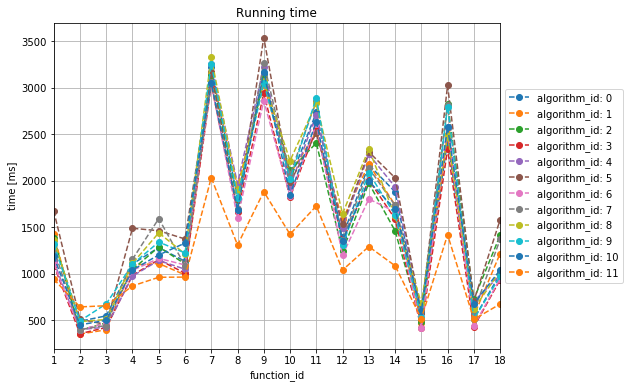

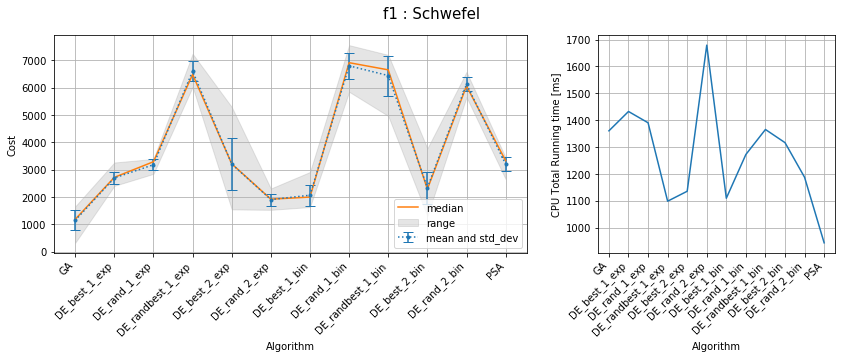

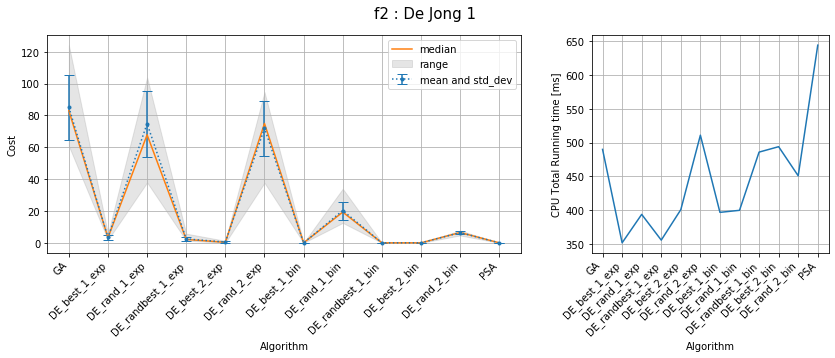

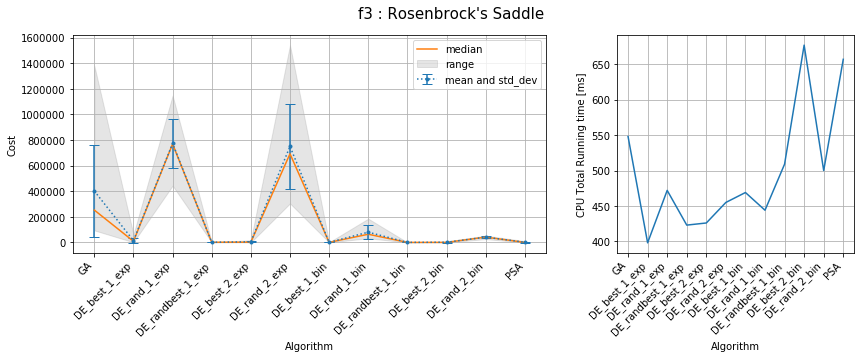

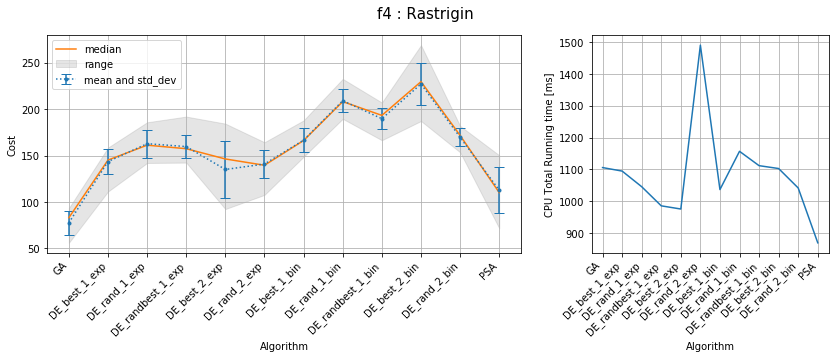

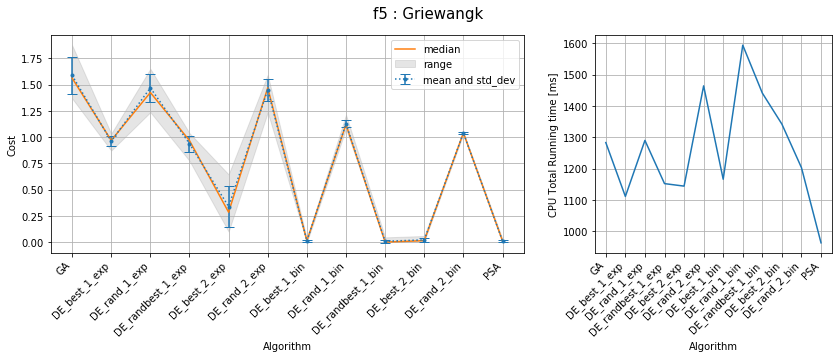

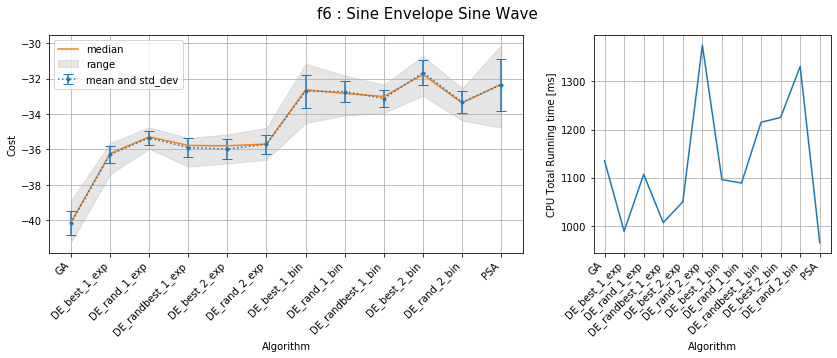

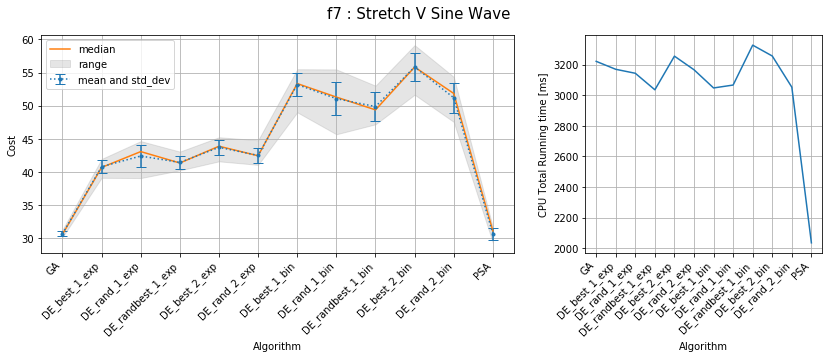

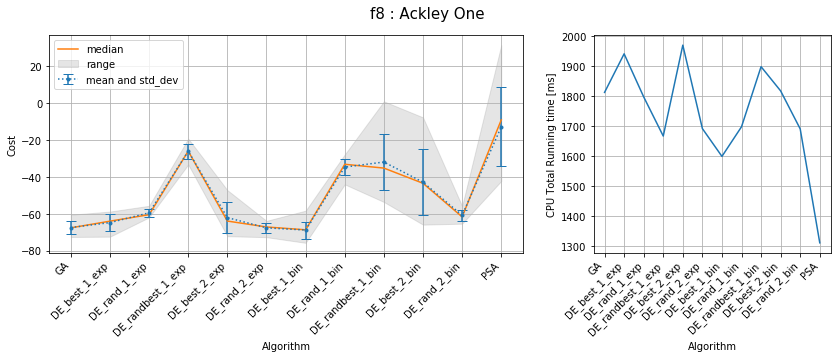

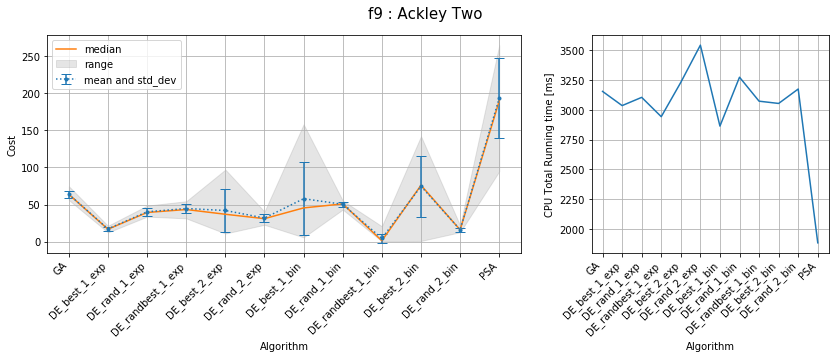

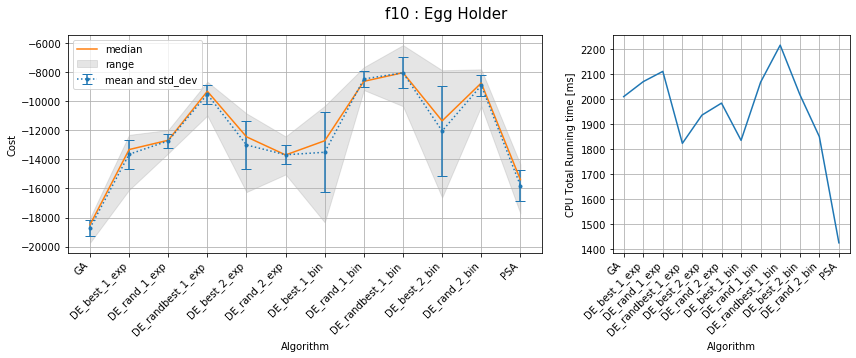

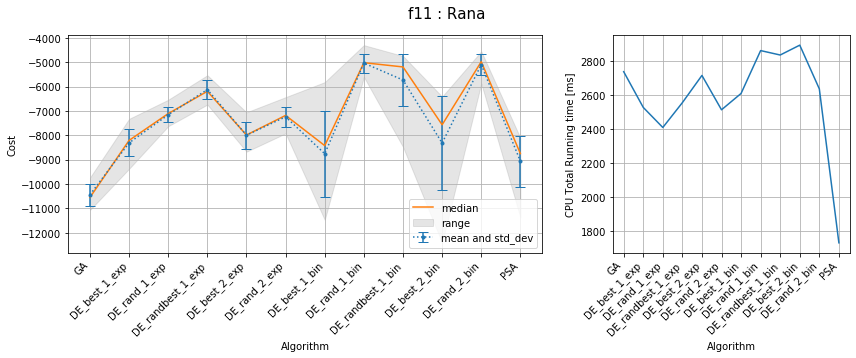

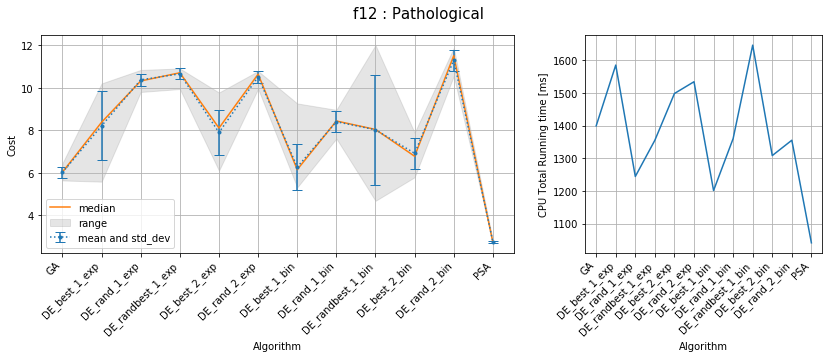

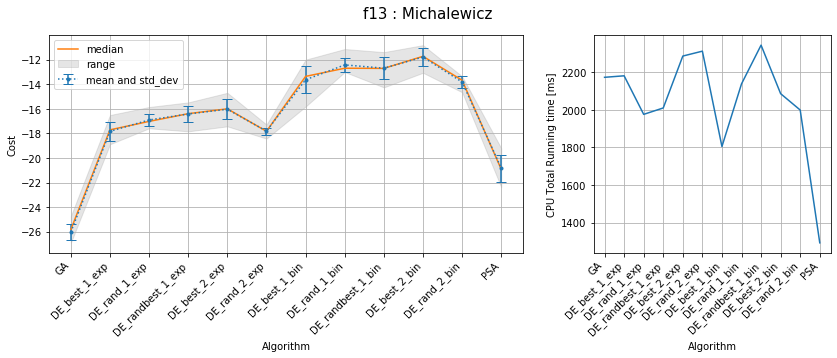

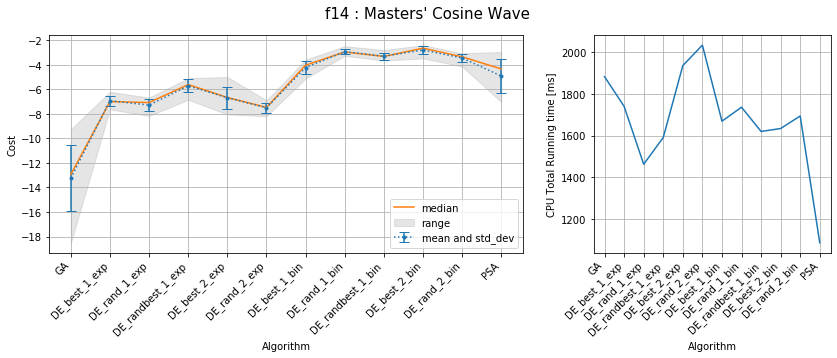

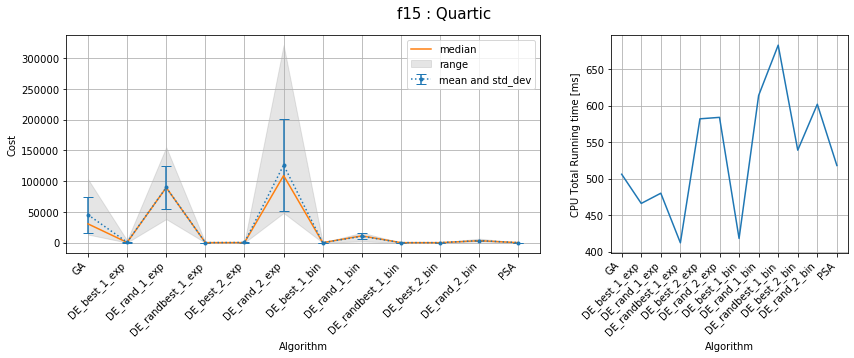

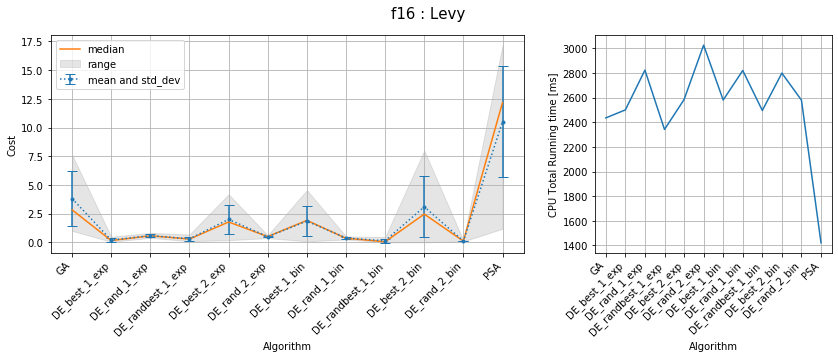

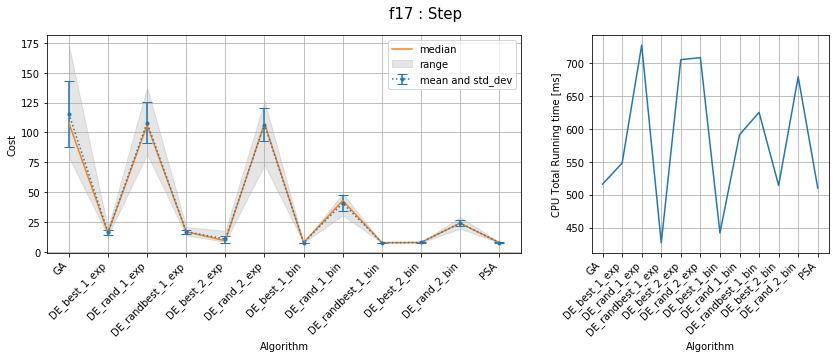

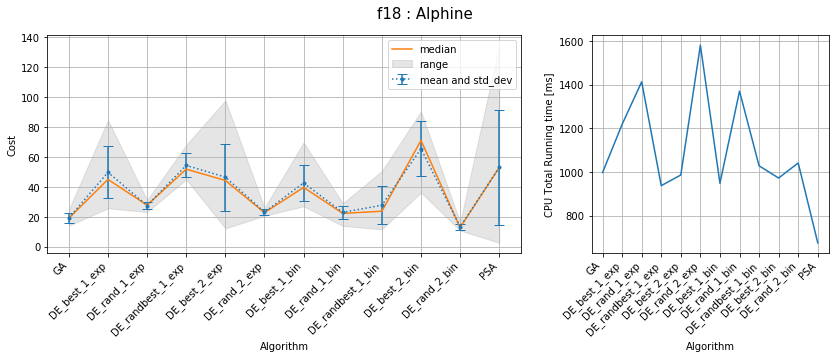

In [172]:
test.plot()

In [8]:
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
test.solution_df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
108,0,1,50,30,-512,512.000,1283.540,397.670,1663.420,1188.860,4941.110,549.778,2213.200
37,0,2,50,30,-100,100.000,80.443,19.623,92.673,80.884,3184.930,41.043,133.716
169,0,3,50,30,-100,100.000,373312.000,280383.000,1225300.000,289204.000,3574.380,104425.000,1329720.000
16,0,4,50,30,-30,30.000,-67980.000,2730.460,13890.400,-67500.500,5541.490,-75765.600,-61875.200
94,0,5,50,30,-500,500.000,1.586,0.127,0.605,1.582,6441.060,1.254,1.859
105,0,6,50,30,-30,30.000,-40.035,0.519,2.385,-40.025,5924.080,-41.210,-38.824
163,0,7,50,30,-30,30.000,30.562,0.467,2.242,30.511,9340.690,29.627,31.869
85,0,8,50,30,-32,32.000,-67.763,2.458,10.290,-67.641,7399.040,-72.528,-62.237
173,0,9,50,30,-32,32.000,62.436,12.255,55.767,60.843,9238.900,42.581,98.348
45,0,10,50,30,-500,500.000,-18305.500,1092.890,4651.760,-18374.100,8133.700,-20561.600,-15909.800


In [7]:
df = test.solution_df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
108,0,1,50,30,-512,512.0,1283.5400,397.67000,1663.42000,1188.8600,4941.11,549.77800,2213.2000
190,1,1,50,30,-512,512.0,2562.0300,430.40800,1982.40000,2511.8300,4207.36,1585.22000,3567.6200
155,2,1,50,30,-512,512.0,3207.3000,263.21600,1118.59000,3232.1900,4163.98,2683.31000,3801.9000
59,3,1,50,30,-512,512.0,6366.2700,296.94100,1605.95000,6403.0300,4016.31,5322.38000,6928.3300
31,4,1,50,30,-512,512.0,3580.5500,728.40600,3037.63000,3533.0100,4275.86,2124.06000,5161.6900
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,6,18,50,30,-100,100.0,58.4819,32.70950,154.50200,53.2827,3977.34,16.53280,171.0350
98,7,18,50,30,-100,100.0,26.0693,3.36186,17.59480,26.4200,3964.83,16.85670,34.4515
3,8,18,50,30,-100,100.0,27.3574,12.89780,60.26210,25.1350,4352.10,9.88536,70.1475
189,9,18,50,30,-100,100.0,101.8670,51.23770,226.80300,92.7890,4234.29,34.30040,261.1030


# Read solution.csv, generate plot and latex report

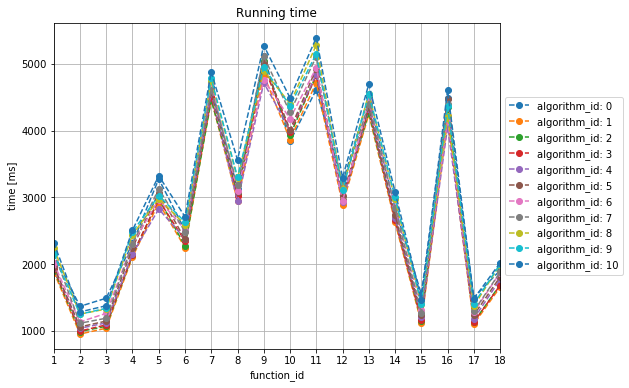

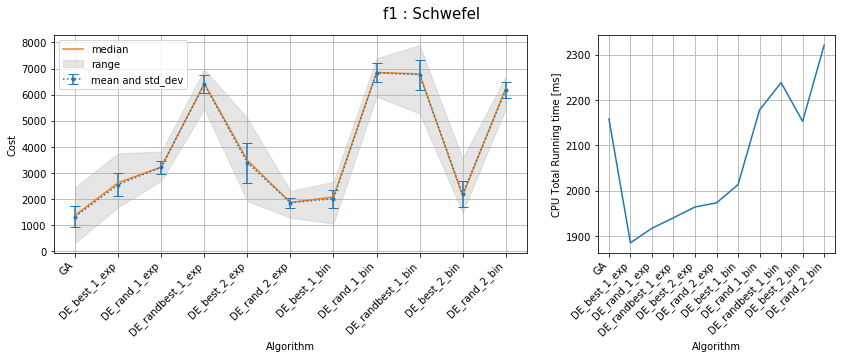

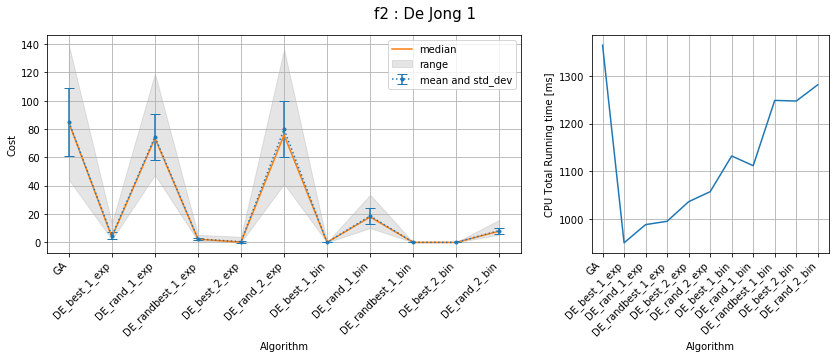

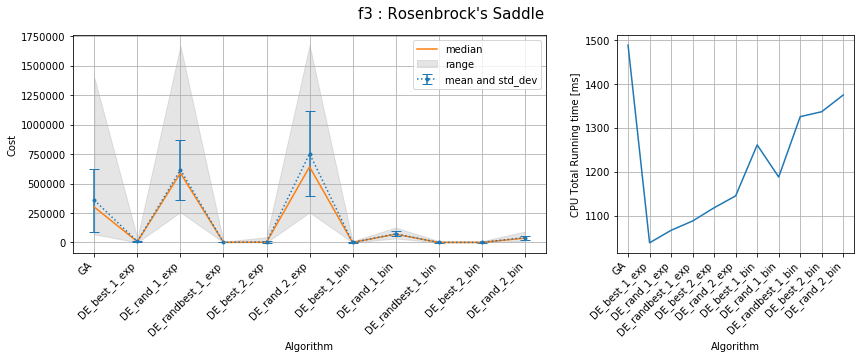

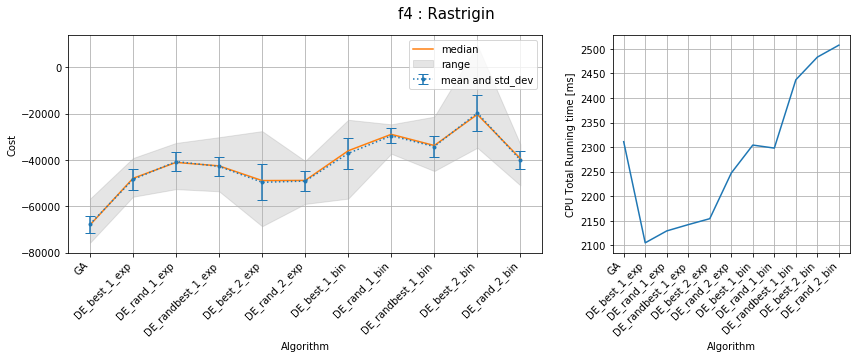

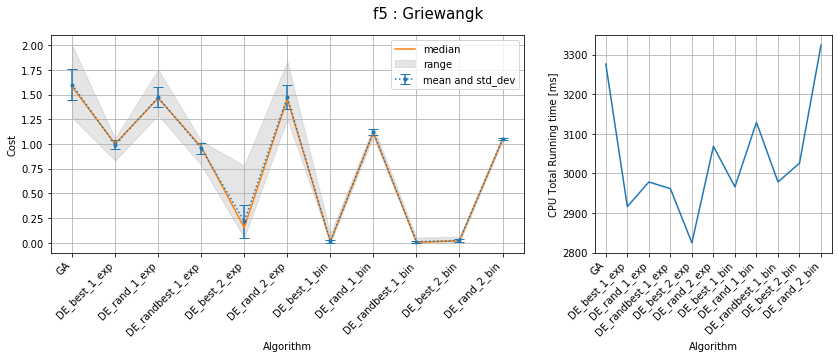

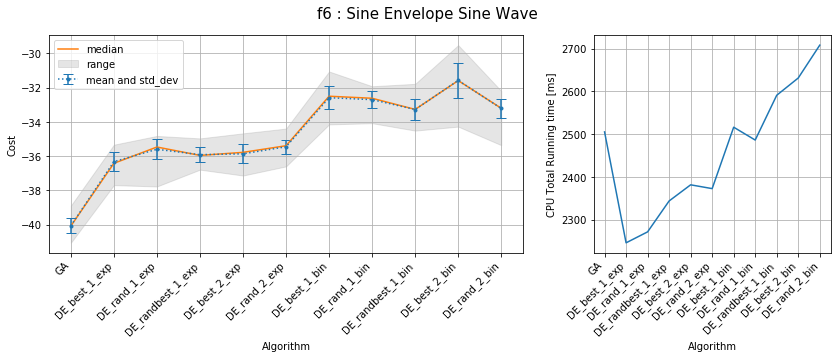

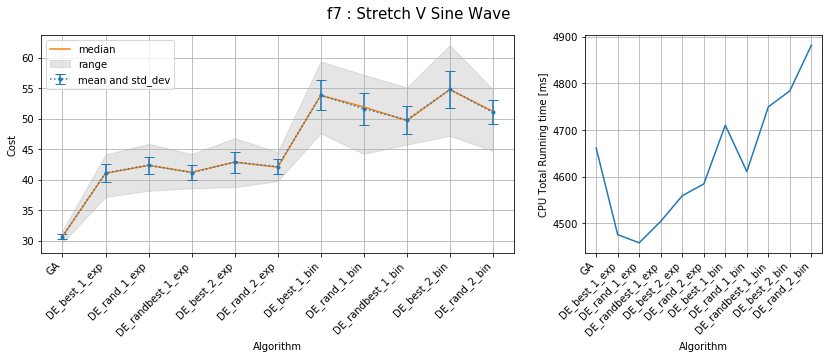

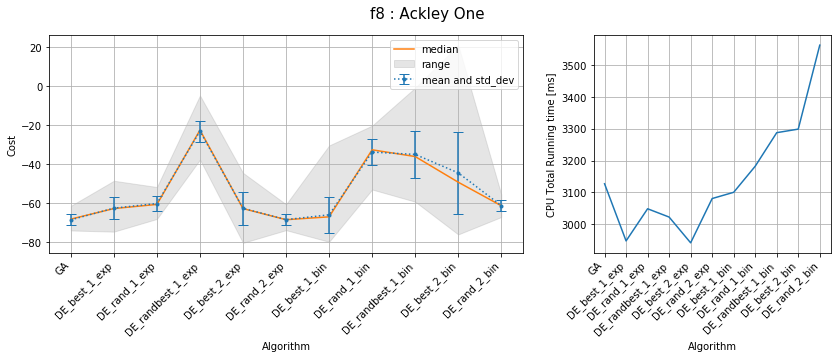

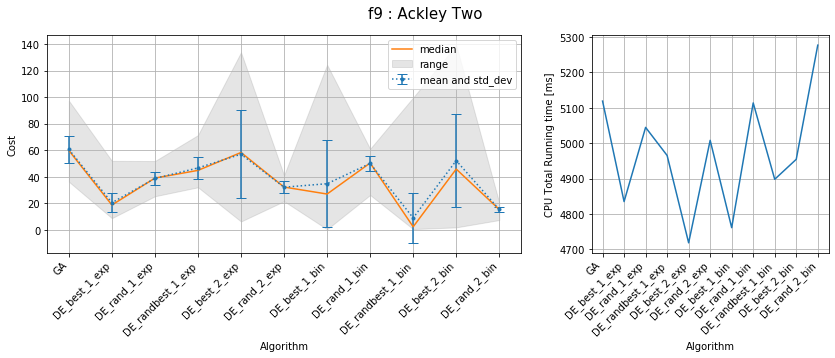

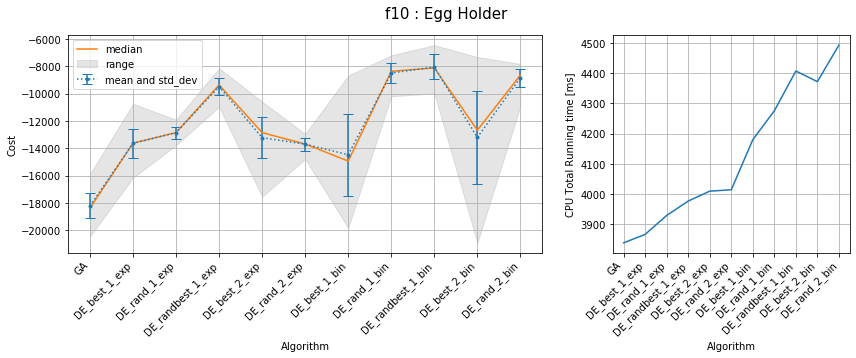

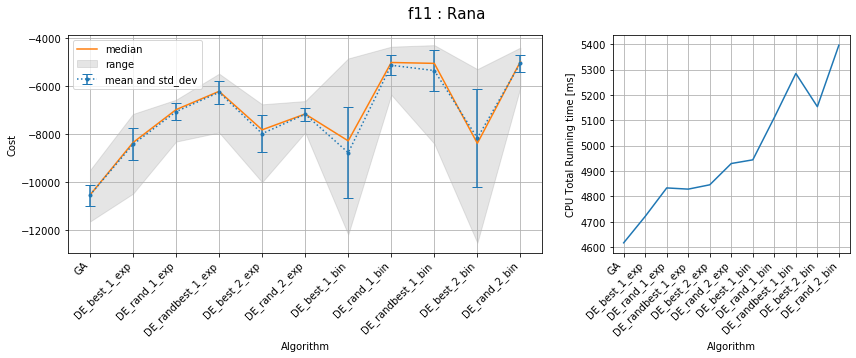

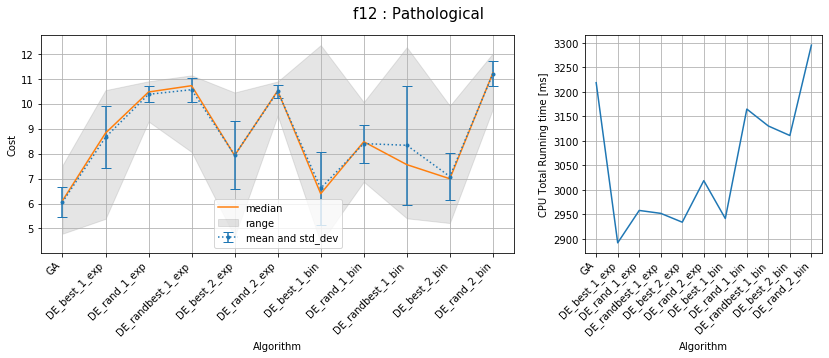

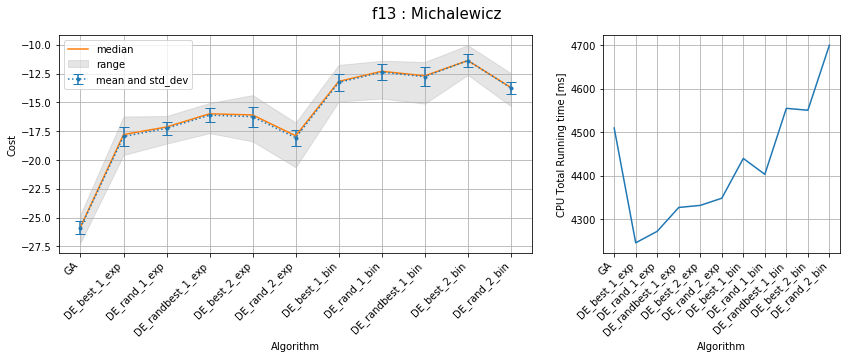

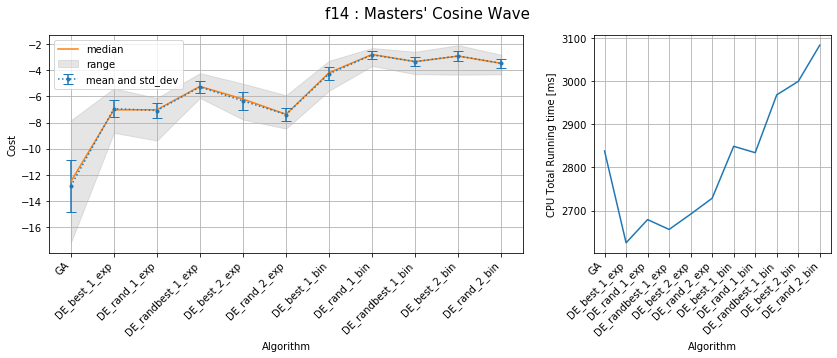

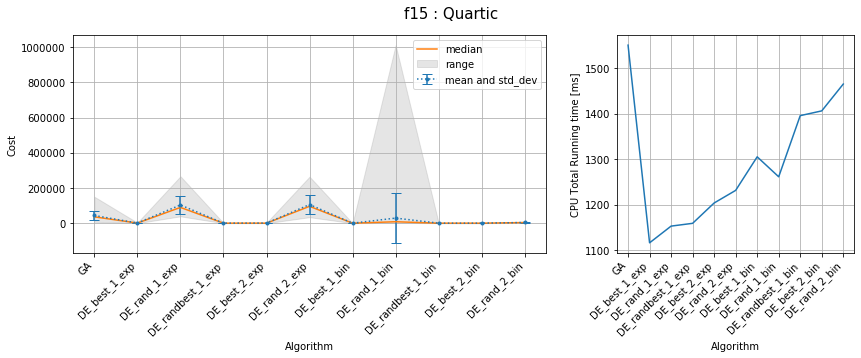

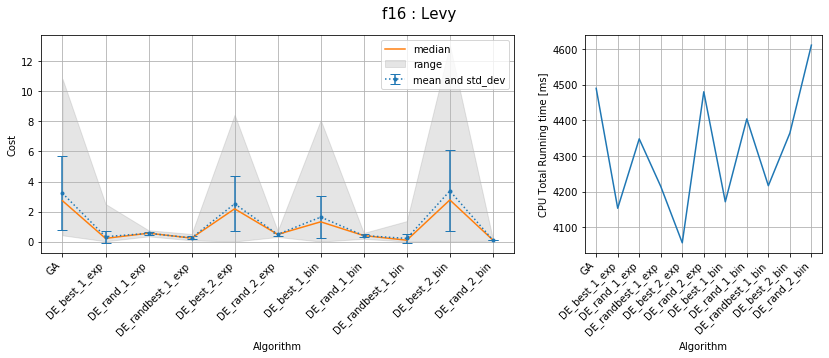

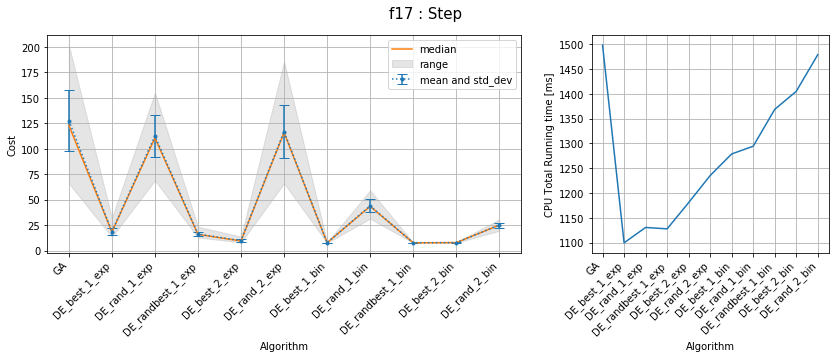

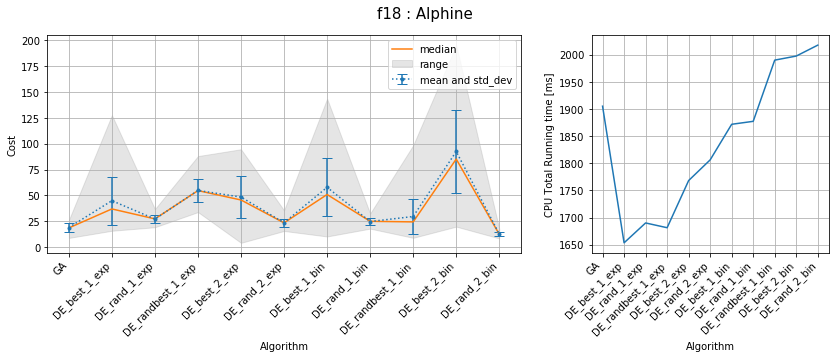

In [4]:
df=pd.read_csv("../out/optimization - linux 1 cpu/"+'solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)


#-----------plot running time
fig, ax = plt.subplots(figsize=(8,6))
for label, data in df.groupby('algorithm_id'):
    data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
plt.ylabel('time [ms]')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.title('Running time')
#plt.savefig("running_time.png",bbox_inches='tight')


#---------plot statistics
for id, data in df.groupby('function_id'):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
    ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
    ax1.plot(data['algorithm_id'],data['median'],label='median')
    ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
    locs = [int(i) for i in test.opt_param_list_id]
    names = test.opt_param_list_name
    ax1.set_xticks(locs, minor=False)
    ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
    #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
    fig.suptitle("f%d : %s"%(id, test.f_param_list_name[id-1]), fontsize=15)
    #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.legend()
    ax1.set_xlabel('Algorithm')
    ax1.set_ylabel('Cost')
    ax1.grid()
    
    ax2.plot(data['algorithm_id'],data['time_ms'])
    ax2.set_ylabel('CPU Total Running time [ms]')
    ax2.set_xlabel('Algorithm')
    ax2.set_xticks(locs, minor=False)
    ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
    ax2.grid()
    #plt.savefig("f"+str(id)+".png",bbox_inches='tight')


In [5]:
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
108,0,1,50,30,-512,512.000,1330.170,388.519,2128.950,1379.190,2158.370,322.844,2451.800
37,0,2,50,30,-100,100.000,85.044,23.894,94.983,84.611,1365.260,44.305,139.288
169,0,3,50,30,-100,100.000,358923.000,267559.000,1329880.000,299684.000,1488.010,68740.900,1398620.000
16,0,4,50,30,-30,30.000,-67715.300,3609.350,19036.400,-68065.100,2311.080,-75769.800,-56733.400
94,0,5,50,30,-500,500.000,1.603,0.160,0.732,1.581,3276.470,1.270,2.002
105,0,6,50,30,-30,30.000,-40.070,0.437,2.172,-40.085,2505.260,-41.066,-38.894
163,0,7,50,30,-30,30.000,30.665,0.471,2.021,30.678,4661.080,29.633,31.654
85,0,8,50,30,-32,32.000,-68.615,2.798,12.652,-68.254,3126.870,-74.087,-61.435
173,0,9,50,30,-32,32.000,60.636,10.164,61.166,59.826,5118.920,36.270,97.436
45,0,10,50,30,-500,500.000,-18226.300,915.881,4595.760,-18373.200,3839.400,-20476.500,-15880.700


## support codes for latex report generation

In [7]:
# https://stats.stackexchange.com/questions/124096/two-samples-z-test-in-python
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return round(z, 3), round(pval, 4)

z, p = twoSampZ(1330, 1350, 0, 388.5, 190.64, 50, 50)

In [15]:
df_s = df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df_s
n_sample = df_s["n_runs"].iloc[0]

# print the table and export to latex

In [61]:
def print_latex_function(function_id):
    df_fx = df_s[df_s["function_id"]==function_id] # dataframe of function_id
    
    # get name of the algorithms
    alg_id = [str(i) for i in df_fx["algorithm_id"].values.tolist()] # convert algorithm id to string
    alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
    alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
    # insert algorithms name to the dataframe
    df_fx = df_fx[["mean","std_dev","median","range_min","range_max","time_ms"]]
    df_fx.insert(0,"algorithm",alg_name)
    #display(df_fx)
    
    # get name of the functions
    f_index = test.f_param_list_function_id.index(str(function_id))
    f_name = test.f_param_list_name[f_index]
    
        
    #print subsection 
    print("\\subsection{Function %d: %s}"%(function_id, f_name))
    
    
    #print function
    print("""
    \\begin{figure}[H]
    \\centering
    
    \\includegraphics[width=1\\linewidth]{{"figures/figures - linux 1 cpu/f%d"}.png}
    
    \\caption{Cost and CPU total running time of Function %d: %s} 
    \\label{fig:f%d}
    \\end{figure}
    """%(function_id, function_id, f_name, function_id))


    
    # print latex table
    print("""\\begin{table}[H]
    \\centering
    \\footnotesize""")
    print(df_fx.to_latex(index=False))
    print("""\\caption{Function %d: Statistical Analysis of the Cost} 
    \\end{table}"""%function_id)
    
    
    # Hypothesis testing 
    #find the min beside GA
    #df_ga = df_fx[df_fx["algorithm"]=="GA"]
    #df_fx = df_fx[df_fx["algorithm"]!="GA"]
    min_index = df_fx[['mean']].idxmin()
    df_min = df_fx.loc[min_index] # minimun 
    x1=df_min["mean"].values[0]
    sd1=df_min["std_dev"].values[0]
    
   
    min_latex = df_min["algorithm"].values[0].replace("_","\_")
    print("Best Algorithm: \\\\")
    print("\\textbf{%s}, Cost (mean): %f\\\\"%(min_latex, x1))
        
    # compare everyone with the best
    already_printed=False
    for index, row in df_fx.iterrows():
        if index != min_index.values[0]: #exclude compare with itself
  
            #get name
            current_latex = row["algorithm"].replace("_","\_")
            
            #preparing data for z-test (two sample)
            x2=row["mean"]
            sd2=row["std_dev"]

            z,p = twoSampZ(x1,x2,0,sd1,sd2,n_sample,n_sample)

            

            if(p>0.05):
                if not already_printed:
                    print("\\noindent")
                    print("\\textbf{Two-Sample Z-Test Hypothesis Testing: }")
                    print("confidence interval = 95\%\\\\")
                    already_printed = True
          
                print("\\textbf{%s}, Cost (mean): %f"%(current_latex, x2))
                print(" P value: %f   "%p)
                print("\\textbf{the cost of %s is equal to the cost of %s}.\\\\"%(current_latex, min_latex))

print_latex_function(8)

\subsection{Function 8: Ackley One}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures - linux 1 cpu/f8"}.png}
    
    \caption{Cost and CPU total running time of Function 8: Ackley One} 
    \label{fig:f8}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &    mean &  std\_dev &  median &  range\_min &  range\_max &  time\_ms \\
\midrule
                GA & -68.615 &    2.798 & -68.254 &    -74.087 &    -61.435 & 3126.870 \\
     DE\_best\_1\_exp & -62.618 &    5.764 & -62.828 &    -74.697 &    -48.541 & 2947.120 \\
     DE\_rand\_1\_exp & -60.235 &    3.611 & -60.705 &    -68.175 &    -51.756 & 3048.230 \\
 DE\_randbest\_1\_exp & -23.060 &    5.377 & -22.526 &    -37.711 &     -4.706 & 3022.120 \\
     DE\_best\_2\_exp & -62.723 &    8.563 & -62.830 &    -80.437 &    -44.481 & 2941.100 \\
     DE\_rand\_2\_exp & -68.522 &    2.789 & -68.553 &    -73.931 &    

## Print latex

In [60]:
function_list = df_s["function_id"].unique()
for i in function_list:
    print_latex_function(i)

\subsection{Function 1: Schwefel}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures - linux 1 cpu/f1"}.png}
    
    \caption{Cost and CPU total running time of Function 1: Schwefel} 
    \label{fig:f1}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &     mean &  std\_dev &   median &  range\_min &  range\_max &  time\_ms \\
\midrule
                GA & 1330.170 &  388.519 & 1379.190 &    322.844 &   2451.800 & 2158.370 \\
     DE\_best\_1\_exp & 2554.650 &  454.357 & 2625.350 &   1692.530 &   3758.570 & 1885.140 \\
     DE\_rand\_1\_exp & 3221.480 &  245.530 & 3226.450 &   2698.210 &   3818.370 & 1917.270 \\
 DE\_randbest\_1\_exp & 6393.850 &  341.369 & 6432.170 &   5447.420 &   6967.870 & 1940.380 \\
     DE\_best\_2\_exp & 3393.730 &  766.011 & 3481.430 &   1919.550 &   5097.510 & 1964.200 \\
     DE\_rand\_2\_exp & 1859.860 &  190.640 & 1870.870 &   1285


\caption{Function 17: Statistical Analysis of the Cost} 
    \end{table}
Best Algorithm: \\
\textbf{DE\_randbest\_1\_bin}, Cost (mean): 7.673640\\
\subsection{Function 18: Alphine}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures - linux 1 cpu/f18"}.png}
    
    \caption{Cost and CPU total running time of Function 18: Alphine} 
    \label{fig:f18}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &   mean &  std\_dev &  median &  range\_min &  range\_max &  time\_ms \\
\midrule
                GA & 18.903 &    4.296 &  18.499 &      8.833 &     26.103 & 1905.180 \\
     DE\_best\_1\_exp & 44.836 &   23.021 &  36.868 &     15.752 &    127.641 & 1653.390 \\
     DE\_rand\_1\_exp & 27.128 &    3.951 &  27.255 &     19.172 &     36.741 & 1690.010 \\
 DE\_randbest\_1\_exp & 54.767 &   11.171 &  54.614 &     33.832 &     88.008 & 1681.220 \\
     DE\_best\_2\_exp &

# print summary table

In [18]:
df_summary = df.sort_values(by=['algorithm_id','function_id'], inplace = False)
df_summary

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
108,0,1,50,30,-512,512.000,1330.170,388.519,2128.950,1379.190,2158.370,322.844,2451.800
37,0,2,50,30,-100,100.000,85.044,23.894,94.983,84.611,1365.260,44.305,139.288
169,0,3,50,30,-100,100.000,358923.000,267559.000,1329880.000,299684.000,1488.010,68740.900,1398620.000
16,0,4,50,30,-30,30.000,-67715.300,3609.350,19036.400,-68065.100,2311.080,-75769.800,-56733.400
94,0,5,50,30,-500,500.000,1.603,0.160,0.732,1.581,3276.470,1.270,2.002
105,0,6,50,30,-30,30.000,-40.070,0.437,2.172,-40.085,2505.260,-41.066,-38.894
163,0,7,50,30,-30,30.000,30.665,0.471,2.021,30.678,4661.080,29.633,31.654
85,0,8,50,30,-32,32.000,-68.615,2.798,12.652,-68.254,3126.870,-74.087,-61.435
173,0,9,50,30,-32,32.000,60.636,10.164,61.166,59.826,5118.920,36.270,97.436
45,0,10,50,30,-500,500.000,-18226.300,915.881,4595.760,-18373.200,3839.400,-20476.500,-15880.700


In [66]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = alg_name[int(label)]
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
display(df_result)
print(df_result.to_latex(index=False))

,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin
0,1,1330.170,2554.650,3221.480,6393.850,3393.730,1859.860,2012.120,6833.980,6764.300,2187.930,6168.990
1,2,85.044,4.529,74.558,2.406,0.459,79.866,0.004,18.665,0.002,0.007,8.319
2,3,358923.000,8366.080,616375.000,1634.280,3820.620,753439.000,520.354,72972.600,562.328,1048.130,41223.200
3,4,-67715.300,-48389.100,-40661.400,-42764.300,-49615.600,-49116.300,-37136.400,-29531.800,-34185.400,-19621.900,-40013.100
4,5,1.603,0.993,1.474,0.956,0.217,1.475,0.015,1.121,0.011,0.023,1.048
5,6,-40.070,-36.327,-35.602,-35.918,-35.868,-35.457,-32.592,-32.704,-33.280,-31.581,-33.217
6,7,30.665,41.091,42.384,41.151,42.875,42.142,53.829,51.646,49.805,54.797,51.045
7,8,-68.615,-62.618,-60.235,-23.060,-62.723,-68.522,-66.035,-33.812,-35.009,-44.479,-61.283
8,9,60.636,20.410,38.721,46.666,57.006,32.124,34.759,50.078,8.953,52.178,15.336
9,10,-18226.300,-13635.300,-12848.900,-9469.860,-13220.500,-13696.800,-14468.300,-8478.360,-8036.620,-13206.800,-8821.480


\begin{tabular}{rrrrrrrrrrrr}
\toprule
 function\_id &         GA &  DE\_best\_1\_exp &  DE\_rand\_1\_exp &  DE\_randbest\_1\_exp &  DE\_best\_2\_exp &  DE\_rand\_2\_exp &  DE\_best\_1\_bin &  DE\_rand\_1\_bin &  DE\_randbest\_1\_bin &  DE\_best\_2\_bin &  DE\_rand\_2\_bin \\
\midrule
           1 &   1330.170 &       2554.650 &       3221.480 &           6393.850 &       3393.730 &       1859.860 &       2012.120 &       6833.980 &           6764.300 &       2187.930 &       6168.990 \\
           2 &     85.044 &          4.529 &         74.558 &              2.406 &          0.459 &         79.866 &          0.004 &         18.665 &              0.002 &          0.007 &          8.319 \\
           3 & 358923.000 &       8366.080 &     616375.000 &           1634.280 &       3820.620 &     753439.000 &        520.354 &      72972.600 &            562.328 &       1048.130 &      41223.200 \\
           4 & -67715.300 &     -48389.100 &     -40661.400 &         -42764.300 &     -49615

In [67]:
df_result

,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin
0,1,1330.170,2554.650,3221.480,6393.850,3393.730,1859.860,2012.120,6833.980,6764.300,2187.930,6168.990
1,2,85.044,4.529,74.558,2.406,0.459,79.866,0.004,18.665,0.002,0.007,8.319
2,3,358923.000,8366.080,616375.000,1634.280,3820.620,753439.000,520.354,72972.600,562.328,1048.130,41223.200
3,4,-67715.300,-48389.100,-40661.400,-42764.300,-49615.600,-49116.300,-37136.400,-29531.800,-34185.400,-19621.900,-40013.100
4,5,1.603,0.993,1.474,0.956,0.217,1.475,0.015,1.121,0.011,0.023,1.048
5,6,-40.070,-36.327,-35.602,-35.918,-35.868,-35.457,-32.592,-32.704,-33.280,-31.581,-33.217
6,7,30.665,41.091,42.384,41.151,42.875,42.142,53.829,51.646,49.805,54.797,51.045
7,8,-68.615,-62.618,-60.235,-23.060,-62.723,-68.522,-66.035,-33.812,-35.009,-44.479,-61.283
8,9,60.636,20.410,38.721,46.666,57.006,32.124,34.759,50.078,8.953,52.178,15.336
9,10,-18226.300,-13635.300,-12848.900,-9469.860,-13220.500,-13696.800,-14468.300,-8478.360,-8036.620,-13206.800,-8821.480


## get best cost without time

In [69]:
df_best = df_result[["function_id"]]
df_best["algorithm_id"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,algorithm_id,best_cost
0,1,GA,1330.170
1,2,DE_randbest_1_bin,0.002
2,3,DE_best_1_bin,520.354
3,4,GA,-67715.300
4,5,DE_randbest_1_bin,0.011
5,6,GA,-40.070
6,7,GA,30.665
7,8,GA,-68.615
8,9,DE_randbest_1_bin,8.953
9,10,GA,-18226.300


## get best cost with time

In [70]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = int(label)
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
#display(df_result)
#print(df_result.to_latex(index=False))

In [71]:
df_best = df_result[["function_id"]]
df_best["algorithm_id"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
temp = df[["algorithm_id", "function_id", "time_ms"]]
df_best = df_best.merge(temp, on=["function_id","algorithm_id"], how='left') 
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,algorithm_id,best_cost,time_ms
0,1,0,1330.170,2158.370
1,2,8,0.002,1249.120
2,3,6,520.354,1260.940
3,4,0,-67715.300,2311.080
4,5,8,0.011,2978.360
5,6,0,-40.070,2505.260
6,7,0,30.665,4661.080
7,8,0,-68.615,3126.870
8,9,8,8.953,4897.940
9,10,0,-18226.300,3839.400
